# Taxi Demand-Supply Gap Prediction #

## Load Packages ##

In [3]:
import pandas as pd
import numpy as np
import json, gc
import matplotlib.pyplot as plt

## Load & Inspect Data ##

In [5]:
data_dir = "/home/lee/Documents/DatasetsForGitHub/Taxi_Trajectory_Prediction/"

### GPS Coordinates and Paths ###

First check the ranges of the GPS coordinates. Load the file in chunks to avoid using too much memory. 

In [6]:
check_coordinates = pd.read_csv(data_dir+"train.csv",
                   chunksize=10000,
                   usecols=['POLYLINE'],
                   converters={'POLYLINE': lambda x: json.loads(x)})

lat_min_l = []
lon_min_l = []
lat_max_l = []
lon_max_l = []

for chunk in check_coordinates:

    latlon = np.array([(lat, lon) 
                       for path in chunk['POLYLINE']
                       for lon, lat in path if len(path) > 0])

    lat_min, lon_min = np.nanmin(latlon, axis=0)
    lat_max, lon_max = np.nanmax(latlon, axis=0)  
     
    lat_min_l.append(lat_min)
    lon_min_l.append(lon_min)
    lat_max_l.append(lat_max)
    lon_max_l.append(lat_max)
    
print("minimum latitude: {}".format(min(lat_min_l)))
print("maximum latitude: {}".format(max(lat_max_l)))
print("minimum longitude: {}".format(min(lon_min_l)))
print("maximum longitude: {}".format(max(lon_max_l)))

gc.collect()

minimum latitude: 31.992111
maximum latitude: 51.037119
minimum longitude: -36.913779
maximum longitude: 51.037119


14

The region formed by these coordinates is profoundly larger than Porto. In fact, most of the region is in the ocean. 

I also spot-check some coordinates that are far away from Porto. While they appear valid (other cities of Portugal), I do not intend to include other cities in the prediction. Now limit the coordinates to Porto. 

In [7]:
del check_coordinates, lat_min, lat_max, lon_min, lon_max, latlon, lat_min_l, lon_min_l, lat_max_l, lon_max_l

lat_min, lat_max = 41.04961, 41.24961
lon_min, lon_max = -8.71099, -8.51099

Now produce a heatmap of the taxi paths.

In [8]:
bins = 1000
z = np.zeros((bins, bins))

# run the generator to restart the generation
data = pd.read_csv(data_dir+"train.csv",
                   chunksize=10000,
                   usecols=['POLYLINE'],
                   converters={'POLYLINE': lambda x: json.loads(x)})

for chunk in data:

    latlon = np.array([(lat, lon) 
                       for path in chunk.POLYLINE
                       for lon, lat in path if len(path) > 0])

    z += np.histogram2d(*latlon.T, bins=bins, 
                        range=[[lat_min, lat_max],
                               [lon_min, lon_max]])[0]
        
log_density = np.log(1+z)

14

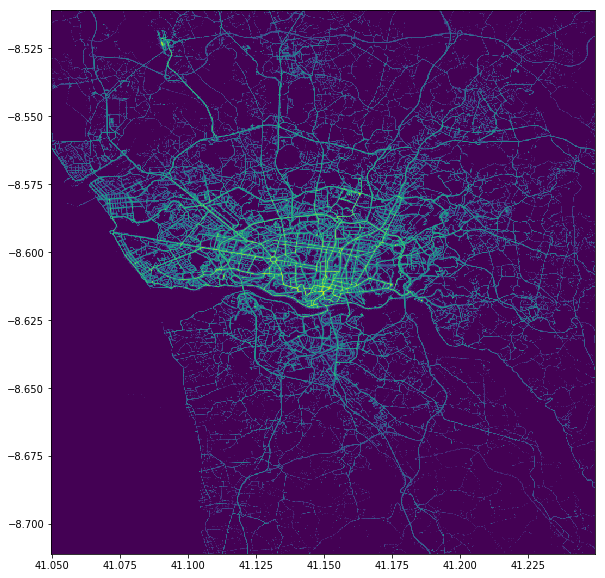

In [9]:
plt.figure(figsize=(10, 10))

# heatmap for the coordinates
plt.imshow(log_density[::-1,:], # flip vertically to suit map convention
           extent=[lat_min, lat_max, lon_min, lon_max])

del latlon, z, log_density
gc.collect()

### Check Missing ###

In [35]:
df = pd.read_csv(data_dir+"train.csv").drop('POLYLINE', axis=1)
df['start_time'] = pd.to_datetime(df['TIMESTAMP'], unit='s')

In [70]:
print("% of missing data of each field:\n")
df.isnull().mean()

% of missing data of each field:



NameError: name 'df' is not defined

In [ ]:
# supply is trip endpoint, taxi availability

# extract end locations of each taxi trip
taxi_end = pd.read_csv(data_dir+"train.csv",
                   usecols=['POLYLINE'],
                   converters={'POLYLINE': lambda x: json.loads(x)[-1:]})

taxi_end.rename(columns={"POLYLINE": "end_loc"}, inplace=True)

add_end = pd.concat([df, taxi_end], axis=1, sort=False)

supply = add_end.sort_values(by=['TAXI_ID', 'start_time'])

We use the start time of the taxi's next trip as an approximation of the current trip's end time. A taxi is at this time available. This end time is left-censored.

In [37]:
supply['end_time'] = supply['start_time'].shift(-1)

supply.loc[(supply['TAXI_ID'] != supply.shift(-1)['TAXI_ID']) 
           | ((supply['end_time'] - supply['start_time']).astype('timedelta64[h]') > 24), 'end_time'] = pd.NaT

supply.sort_index(inplace=True)

supply.drop(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TIMESTAMP',\
             'DAY_TYPE', 'MISSING_DATA', 'start_time'], axis=1, inplace=True)

supply['end_lon'] = supply['end_loc'].apply(lambda x: x[0][0] if len(x)>0 else np.nan)
supply['end_lat'] = supply['end_loc'].apply(lambda x: x[0][1] if len(x)>0 else np.nan)

supply_local = supply[(supply['end_lat']>=lat_min) & (supply['end_lat']<=lat_max) \
                      & (supply['end_lon']>=lon_min) & (supply['end_lon']<=lon_max)].copy()

In [38]:
# start locations of each taxi trip
taxi_start = pd.read_csv(data_dir+"train.csv",
                   usecols=['POLYLINE'],
                   converters={'POLYLINE': lambda x: json.loads(x)[0:1]})
taxi_start.rename(columns={"POLYLINE": "start_loc"}, inplace=True)

demand = pd.concat([df, taxi_start], axis=1, sort=False)

demand.drop(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TIMESTAMP',\
             'DAY_TYPE', 'MISSING_DATA'], axis=1, inplace=True)

demand['start_lon'] = demand['start_loc'].apply(lambda x: x[0][0] if len(x)>0 else np.nan)
demand['start_lat'] = demand['start_loc'].apply(lambda x: x[0][1] if len(x)>0 else np.nan)

demand_local = demand[(demand['start_lat']>=lat_min) & (demand['start_lat']<=lat_max) \
                      & (demand['start_lon']>=lon_min) & (demand['start_lon']<=lon_max)].copy()

In [39]:
del df, taxi_end, add_end, supply, taxi_start, demand
gc.collect()

42

In [40]:
# timestamp to week, day, hour, and minute
demand_local['week'] = demand_local['start_time'].dt.week
demand_local['dayofweek'] = demand_local['start_time'].dt.dayofweek
demand_local['hour'] = demand_local['start_time'].dt.hour
demand_local['minute'] = demand_local['start_time'].dt.minute

demand_local['lon_localized'] = np.floor((demand_local['start_lon']-lon_min) / 0.01)
demand_local['lat_localized'] = np.floor((demand_local['start_lat']-lat_min) / 0.01)

supply_local['week'] = supply_local['end_time'].dt.week
supply_local['dayofweek'] = supply_local['end_time'].dt.dayofweek
supply_local['hour'] = supply_local['end_time'].dt.hour
supply_local['minute'] = supply_local['end_time'].dt.minute

supply_local['lon_localized'] = np.floor((supply_local['end_lon']-lon_min) / 0.01)
supply_local['lat_localized'] = np.floor((supply_local['end_lat']-lat_min) / 0.01)

In [41]:
demand_pvt = demand_local.pivot_table(['TAXI_ID'], index=['week', 'dayofweek', 'hour', 'minute', 'lon_localized', \
                                                    'lat_localized'], aggfunc='count', fill_value=0)

demand_pvt.rename(columns={'TAXI_ID': 'demand'}, inplace=True)

supply_pvt = supply_local.pivot_table(['TAXI_ID'], index=['week', 'dayofweek', 'hour', 'minute', 'lon_localized', \
                                                    'lat_localized'], aggfunc='count', fill_value=0)

supply_pvt.rename(columns={'TAXI_ID': 'supply'}, inplace=True)

In [42]:
gap = demand_pvt.join(supply_pvt, how='outer').fillna(0).reset_index()
gap['gap'] = gap['demand'] - gap['supply']

In [43]:
time_slice = 10 # in minutes

In [44]:
gap['time_window'] = np.floor((gap['hour']*60 + gap['minute'])/time_slice)

# data for each coordinates grid and time window
grid = gap.groupby(by=['week', 'dayofweek', 'time_window', 'lon_localized', 'lat_localized'], \
                 as_index=False)['demand', 'supply', 'gap'].sum()

In [45]:
del gap, demand_local, supply_local, demand_pvt, supply_pvt

gc.collect()

133

In [46]:
# add zero demand/supply
all_week = sorted(grid['week'].unique().tolist())
all_dayofweek = sorted(grid['dayofweek'].unique().tolist())
all_time_window = sorted(grid['time_window'].unique().tolist())
all_lon_grid = sorted(grid['lon_localized'].unique().tolist())
all_lat_grid = sorted(grid['lat_localized'].unique().tolist())

dummy_index = pd.MultiIndex.from_product([all_week, all_dayofweek, all_time_window, all_lon_grid, all_lat_grid],
                             names=['week', 'dayofweek', 'time_window', 'lon_localized', 'lat_localized'])

dummy = pd.DataFrame(index=dummy_index, columns=['demand', 'supply', 'gap'])
dummy.fillna(0, inplace=True)
dummy.reset_index(inplace=True)

del dummy_index

dummy.update(grid)

In [ ]:
grid_filled = dummy.copy()
del dummy

gc.collect()

In [66]:
# separate forecast & historical data
#create forecast data
forecast_period = 3 #timesteps

grid_filled = grid_filled.sort_values(by=['lon_localized', 'lat_localized', 'week', 'dayofweek', 'time_window'])
grid_filled['gap_forecast'] = grid_filled['gap'].shift(-forecast_period)
grid_filled = grid_filled.drop('gap', axis=1)

#create 6 backward timesteps as features
grid_filled['demand_tm1'] = grid_filled['demand'].shift(periods=1) # t-1
grid_filled['demand_tm2'] = grid_filled['demand'].shift(periods=2)
grid_filled['demand_tm3'] = grid_filled['demand'].shift(periods=3)
grid_filled['demand_tm4'] = grid_filled['demand'].shift(periods=4)
grid_filled['demand_tm5'] = grid_filled['demand'].shift(periods=5)
grid_filled['demand_tm6'] = grid_filled['demand'].shift(periods=6)

grid_filled['supply_tm1'] = grid_filled['supply'].shift(periods=1)
grid_filled['supply_tm2'] = grid_filled['supply'].shift(periods=2)
grid_filled['supply_tm3'] = grid_filled['supply'].shift(periods=3)
grid_filled['supply_tm4'] = grid_filled['supply'].shift(periods=4)
grid_filled['supply_tm5'] = grid_filled['supply'].shift(periods=5)
grid_filled['supply_tm6'] = grid_filled['supply'].shift(periods=6)

grid_filled.fillna(0, inplace=True)
grid_filled.reset_index(drop=True)
grid_filled.sort_values(by=['week', 'dayofweek', 'time_window', 'lon_localized', 'lat_localized'], inplace=True)

In [67]:
gc.collect()

161

In [69]:
# split data into training and testing datasets

train_size = int(0.8 * len(grid_filled))

df_train = grid_filled[:train_size]
df_test = grid_filled[train_size:]

del train_size

df_train.to_pickle(data_dir+"train.pkl")
df_test.to_pickle(data_dir+"test.pkl")